# 💡 STMT MERGING & PROCESSING

## 📌 Overview
This notebook processes the **STMT jobseekers dataset**, merging and processing the data while linking it with a **ROME-to-FAP mapping** to retrieve professional families.

The second part of the notebook **analyses and validates the processed dataset**, checking: The **distribution of job offers** by month (**for the year 2020**) and then for all FAP87 categories

This structured approach ensures a clean, well-aggregated dataset for further labor market analysis (especially linking job offers to job demand from the STMT dataset)


##  📊 Categories of Unemployed People in France
In France, unemployed individuals are categorized into five statistical groups (A to E) by the INSEE (Institut National de la Statistique et des Études économiques) for statistical purposes. 

**Statistical Categories (A to E):**

**Category A:** Job seekers who are not employed, actively seeking work, and registered with France Travail. They must take positive steps to find employment.

**Category B:**** Individuals who have worked up to 78 hours in the last month and are actively seeking employment.

**Category C:** Job seekers who have worked more than 78 hours in the last month and are actively seeking employment.

**Category D:** Individuals not immediately available for work due to reasons like training, illness, or specific professional contracts.

**Category E:** People who are already employed but seeking another job.

The **STMT data** available to us was downloaded in multiple steps separately for categories A, B, and C from the France Travail website ([here](https://statistiques.francetravail.org/stmt/defm?fh=1&nf=0&pp=las&ss=1)). Each CSV file provides the **number of job seekers per category** per commune with more than **5,000 inhabitants**, for each month of the year **2020**. This timeframe was chosen to match the **only available JOCAS 2020 job supply dataset**.

**Structure Example:**
```plaintext
STMT/
│── STMT_categorieA/
│   ├── A - January 2020 STMT.csv
│   ├── A - February 2020 STMT.csv
│   ├── ...
│   ├── A - December 2020 STMT.csv
│
│── STMT_categorieB/
│   ├── B - January 2020 STMT.csv
│   ├── B - February 2020 STMT.csv
│   ├── ...
│   ├── B - December 2020 STMT.csv
│
│── STMT_categorieC/
│   ├── C - January 2020 STMT.csv
│   ├── C - February 2020 STMT.csv
│   ├── ...
│   ├── C - December 2020 STMT.csv
│
```
This notebook processes **monthly STMT CSV files**, standardizes commune names, restructures jobseeker data, and merges it with job classification codes to facilitate comparison with job supply data.

In [2]:
# Import Libraries
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import unidecode # To standardize strings
import re # For regular expression

In [3]:
# Get the project's root directory
base_folder = Path().resolve()  # Gets the current working directory
main_folder = base_folder.parent

# Importing files to be used in the script
commune_names_path = main_folder / "data" / "2- Formatted Data" / "name_communes_5000.csv"
commune_names = pd.read_csv(commune_names_path).squeeze().tolist()  
rome_fap_path = main_folder / "data" / "linking tables" / "Rome_to_Fap_processed.csv"
rome_fap = pd.read_csv(rome_fap_path)

# Specify the paths
folder_path = main_folder / "data" / "1- Raw Data" / "STMT" 
output_file = main_folder / "data" / "2- Formatted Data" / "stmt_demand_processed.csv"  

## 🏗️ 1- DATA PROCESSING: IMPORTING & CLEANING JOBSEEKER DATA

This section automates the extraction and preprocessing of jobseeker data from multiple CSV files. The pipeline follows these key steps:

#### **Step 1: Import and combine raw jobseeker data**
- Loops through all `.csv` files in `folder_path`, extracting the **month** from filenames.
- Reads each file, skipping the first **3 rows** to clean metadata.
- Appends all files into a single dataset (`combined_df`).

#### **Step 2: Clean and structure the dataset**
- Splits `"Commune de plus de 5000 hab."` into **commune name** and **postal code**.
- Identifies **jobseeker columns** (those containing `:`) and converts them to integers.
- Standardizes **commune names** (lowercase, remove accents, unify "Saint").
- Filters to **communes with >5,000 inhabitants** to match with external geographic data.

#### **Step 3: Reshape data to long format**
- Extracts **ROME codes** (first 5 characters before `:`).
- Converts the dataset from **wide to long format**, creating `rome_code` and `jobseekers` columns.
- Removes rows where `jobseekers = 0` or missing.

#### **Step 4: Link job categories and finalize dataset**
- Maps **ROME codes to FAP87 job categories**.
- Aggregates jobseekers by `commune`, `fap87`, and `month`.
- Saves the final cleaned dataset for further analysis.

This process ensures a **structured and standardized dataset**, making jobseeker data easily analyzable. 🚀

In [4]:
%%capture

#-------------------------- IMPORT CSV FILES -------------------------------#

# Empty list to store imported CSV files
dataframes = []

# Loop over each folder in the main directory
for folder in os.listdir(folder_path):
    folder_full_path = os.path.join(folder_path, folder)  # Construct full folder path
    
    # Check if it is a directory
    if os.path.isdir(folder_full_path):
        # Determine category based on folder name
        category = folder.split("_")[-1][-1]  # Extracts 'A', 'B', or 'C'
        
        # Loop over every CSV file in the directory
        for file in os.listdir(folder_full_path):  # Use full path
            if file.endswith('.csv'):
                # Get the full path to the file
                file_path = os.path.join(folder_full_path, file)  # Corrected file path
                
                # Extract month from filename (e.g., "C - Août 2020 STMT.csv")
                try:
                    month = file.split(" - ")[1].split(" ")[0]  # Isolates the month name
                except IndexError:
                    print(f"Skipping file '{file}' due to unexpected name format.")
                    continue
                
                print(f"Processing file: {file}")  # Debugging line
                
                # Read CSV file
                try:
                    df = pd.read_csv(file_path, skiprows=3, delimiter=';', encoding='utf-8', skip_blank_lines=True)
                except Exception as e:
                    print(f"Error reading file {file}: {e}")
                    continue
                
                print(f"DataFrame shape: {df.shape}")  # Debugging line
                
                # Add month column
                df.insert(0, 'month', month)
                
                # Add category column
                df['category'] = category
                
                # Append to list of dataframes
                dataframes.append(df)
    else:
        print(f"Skipping '{folder}' as it is not a folder.")
        
        
#------------------------ PROCESSING / CLEANING -----------------------------#

# Combine all DataFrames
combined_df = pd.concat(dataframes, ignore_index=True)

# Split 'Commune de plus de 5000 hab' into commune name and postal code
combined_df[['commune', 'postal_code']] = combined_df["Commune de plus de 5000 hab."].str.rsplit(' ', n=1, expand=True)

# Identify columns containing a colon in their name (jobseeker columns)
colon_columns = [col for col in combined_df.columns if ':' in col]

# Convert these columns to integers (handling errors gracefully)
for col in colon_columns:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce').fillna(0).astype(int)

# Standardization function (for commune)
def standardize_commune(name):
    if pd.isna(name):
        return None
    name = unidecode.unidecode(name.lower().strip())  # Remove accents & lowercase
    name = re.sub(r"[-'’]", " ", name)  # Remove hyphens & apostrophes
    name = re.sub(r"\bst[ .]", "saint ", name)  # Standardize "St." -> "Saint"
    return name

# Apply standardization
combined_df["commune"] = combined_df["commune"].apply(standardize_commune)

# Filter for communes with more than 5000 habitants (that matches with geofile)
combined_df = combined_df[combined_df["commune"].isin(commune_names)]


#------------------------- CHANGING THE FORMAT -----------------------------#

# Extract ROME codes (first 5 characters before the colon)
rome_mapping = {col: col.split(" :")[0] for col in colon_columns}

# Melt the dataframe from wide to long format
combined_df = combined_df.melt(id_vars=["month", "commune", "category"],  # Preserve 'category'
                  value_vars=colon_columns, 
                  var_name="rome_code", 
                  value_name="jobseekers")

# Replace column names with extracted ROME codes
combined_df["rome_code"] = combined_df["rome_code"].map(rome_mapping)

# Remove rows where 'jobseekers' is NaN or 0 
combined_df = combined_df[combined_df["jobseekers"].notna() & (combined_df["jobseekers"] != 0)]


#-------------------------- LINK ROME TO FAP ------------------------------#

# Merge with linking table: rome to fap
combined_df = combined_df.merge(rome_fap, left_on="rome_code", right_on="rome", how="left")


#----------- COMPUTE SUM JOBSEEKER FAP 87 FOR CATEGORY A AND ABC ----------#

# Group by commune, fap, month, category and count jobseekers
df = combined_df.groupby(["commune", "fap22", "fap87", "month", "category"], as_index=False)["jobseekers"].sum()

# Compute jobseeker_a (sum for category A)
df_a = df[df["category"] == "A"].groupby(["commune", "fap22", "fap87", "month"])["jobseekers"].sum().reset_index()
df_a = df_a.rename(columns={"jobseekers": "jobseeker_a"})

# Compute jobseeker_abc (sum for categories A, B, C)
df_abc = df[df["category"].isin(["A", "B", "C"])].groupby(["commune", "fap22", "fap87", "month"])["jobseekers"].sum().reset_index()
df_abc = df_abc.rename(columns={"jobseekers": "jobseeker_abc"})

# Merge both results
df = df_a.merge(df_abc, on=["commune", "fap22", "fap87", "month"], how="left")


#------------------------ EXPORT FINAL DATASET ----------------------------#

df.to_csv(output_file, index=False)

## 🔍 2- ROBUSTNESS CHECKS / ANALYSIS

Before proceeding with further analysis, this section performs **robustness checks** to ensure the integrity and completeness of the processed dataset. These checks help verify:

- ✅ **Coverage of communes**: Assessing whether most of the expected communes are included.
- ✅ **Distribution of job categories**: Checking the number of distinct `fap87` categories and their distribution.
- ✅ **Temporal consistency**: Ensuring that job offers are distributed across different months as expected.
- ✅ **Data completeness**: Identifying any missing or unexpected values in key columns.

These checks will help confirm that our data processing pipeline has worked correctly and that we have a reliable dataset for analysis. 🚀


In [5]:
# LENGTH OF THE DATASET
print(f"\nLength of the final jobseeker dataset: {len(df)} \n")

# NUMBER OF COMMUNES COVERED
print(f"Number of communes covered out of 2230: {df['commune'].nunique()} \n")

# NUMBER OF FAP COVERED
print(f"Number of FAP87 covered out of 86: {df['fap87'].nunique()} \n")

# NUMBER OF MONTHS COVERED
print(f"Number of months covered out of 12: {df['month'].nunique()}")

# FIRST VIEW OF THE DATASET
df.head()


Length of the final jobseeker dataset: 808627 

Number of communes covered out of 2230: 2230 

Number of FAP87 covered out of 86: 86 

Number of months covered out of 12: 12


,commune,fap22,fap87,month,jobseeker_a,jobseeker_abc
0,abbeville,A,A0Z,April,10,10
1,abbeville,A,A0Z,August,10,10
2,abbeville,A,A0Z,December,10,10
3,abbeville,A,A0Z,February,20,20
4,abbeville,A,A0Z,January,10,20


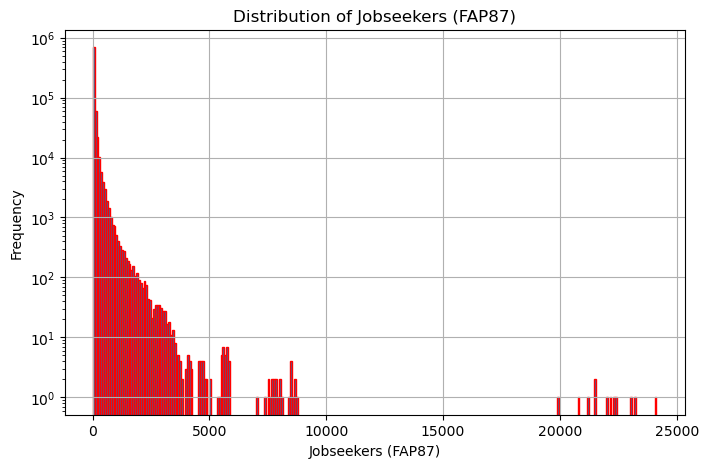

In [6]:
# Distribution of "jobseekers_fap87"
plt.figure(figsize=(8, 5))
df["jobseeker_abc"].hist(bins=300, edgecolor="red")
plt.yscale("log")
plt.xlabel("Jobseekers (FAP87)")
plt.ylabel("Frequency")
plt.title("Distribution of Jobseekers (FAP87)")
plt.show()

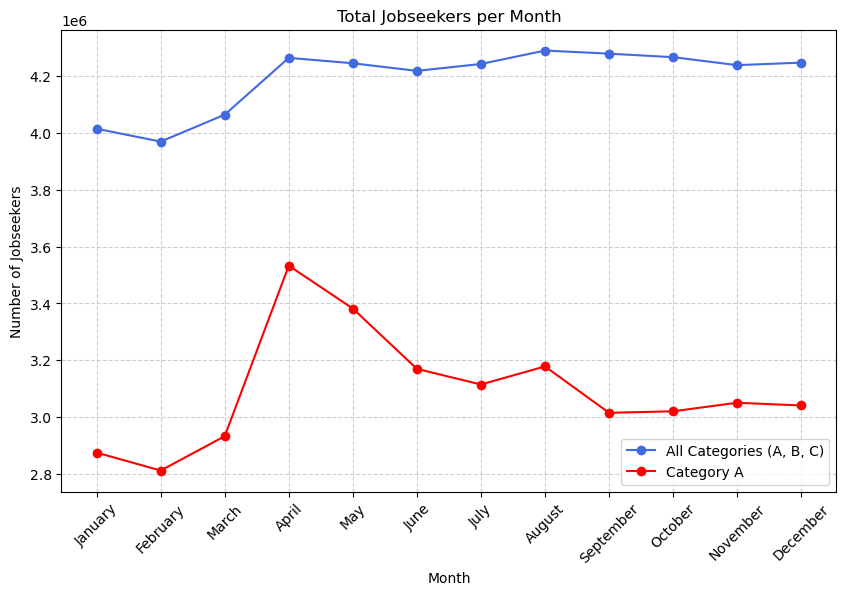

In [7]:
# Ensure chronological order for months
month_order = ["January", "February", "March", "April", "May", "June", "July", 
               "August", "September", "October", "November", "December"]

# Group by month and compute totals for both jobseeker_a and jobseeker_abc
job_month = df.groupby("month", as_index=False).agg({"jobseeker_a": "sum", "jobseeker_abc": "sum"})

# Ensure chronological order of months
job_month["month"] = pd.Categorical(job_month["month"], categories=month_order, ordered=True)

# Sort data
job_month = job_month.sort_values("month")

# Plot both lines
plt.figure(figsize=(10, 6))
plt.plot(job_month["month"], job_month["jobseeker_abc"], marker="o", linestyle="-", color="royalblue", label="All Categories (A, B, C)")
plt.plot(job_month["month"], job_month["jobseeker_a"], marker="o", linestyle="-", color="red", label="Category A")

# Formatting
plt.xlabel("Month")
plt.ylabel("Number of Jobseekers")
plt.title("Total Jobseekers per Month")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


❗This figure on jobseekers in major French communes (2020) shows similar patterns to the France Travail report on total job vacancies in France for the same year. Since both analyses use the same data, discrepancies in jobseeker figures may arise from several factors:

- Exclusion of small communes: Our analysis only includes communes with more than 5,000 inhabitants. In January, communes below this threshold accounted for approximately 1 million jobseekers out of 3.7 million, leading to a downward bias in our numbers.
- Raw vs. adjusted data: The figures below are adjusted for seasonal variations and working-day effects, whereas our dataset consists of raw values due to data availability. The impact of this difference is uncertain.
- Mapping ROME to FAP codes: Transitioning from ROME to FAP codes introduces some duplication of jobseekers, as a single ROME code can correspond to multiple FAP codes. We assume that individuals with the same ROME code can be linked to any matching FAP, regardless of the FAP itself, which may inflate the jobseeker count.
- The data publicly available on France Travail's website --> the number of jobseeker per commune and ROME code is rounded to the closest decimal, which leads to some differences between our estimates and the true total number of jobseekers.

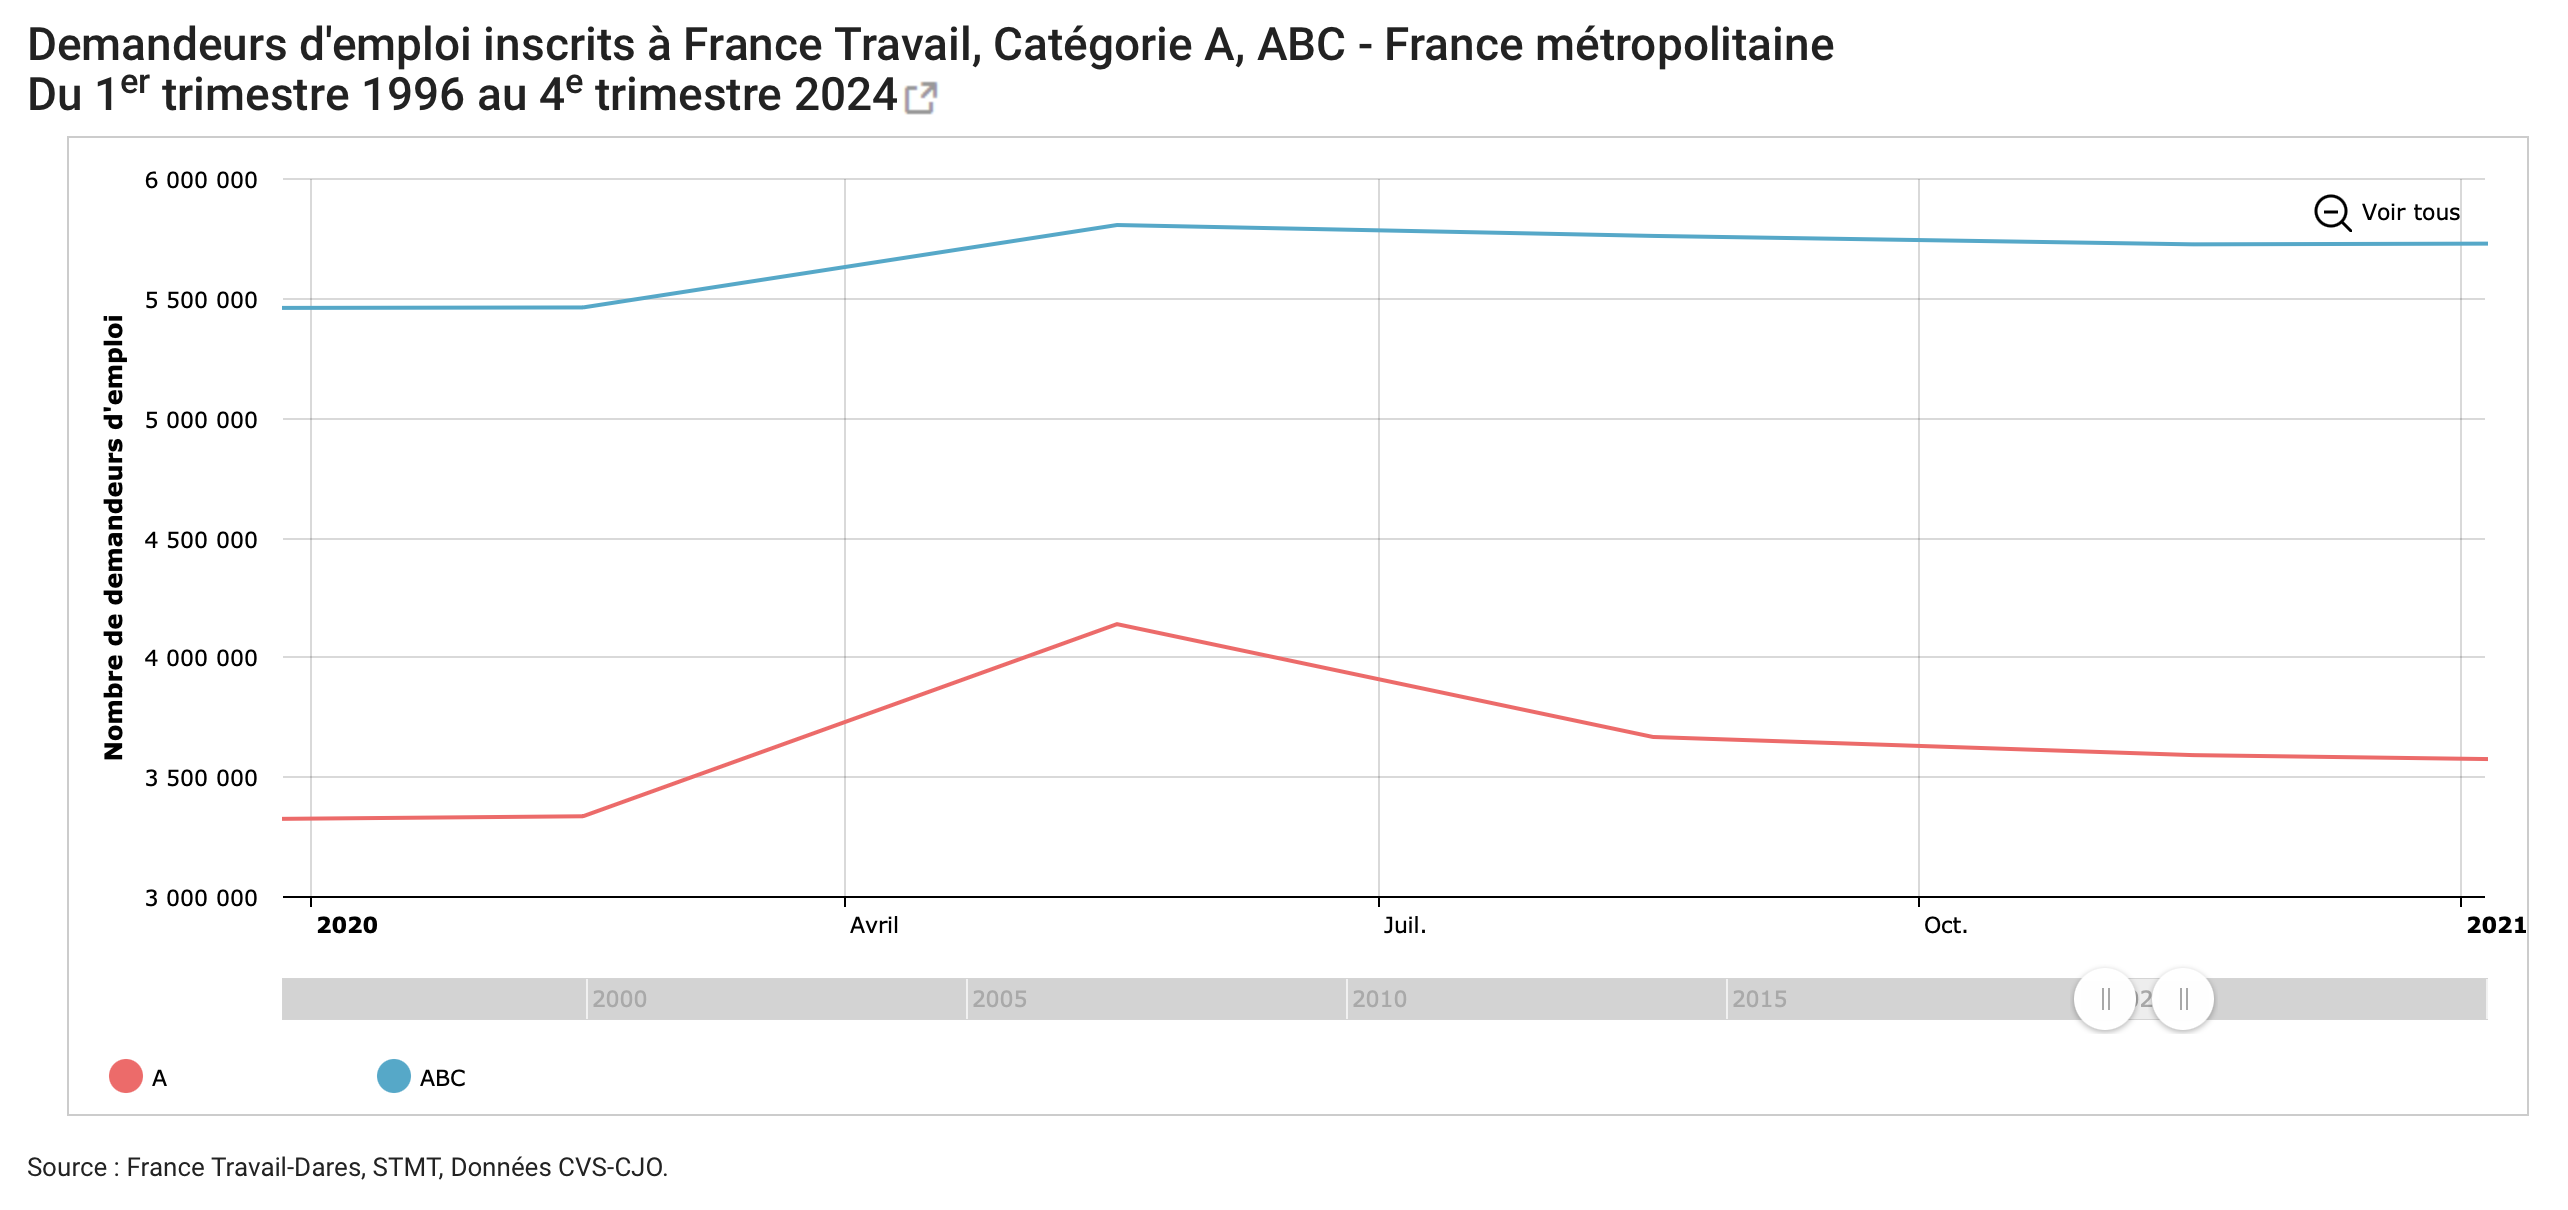!

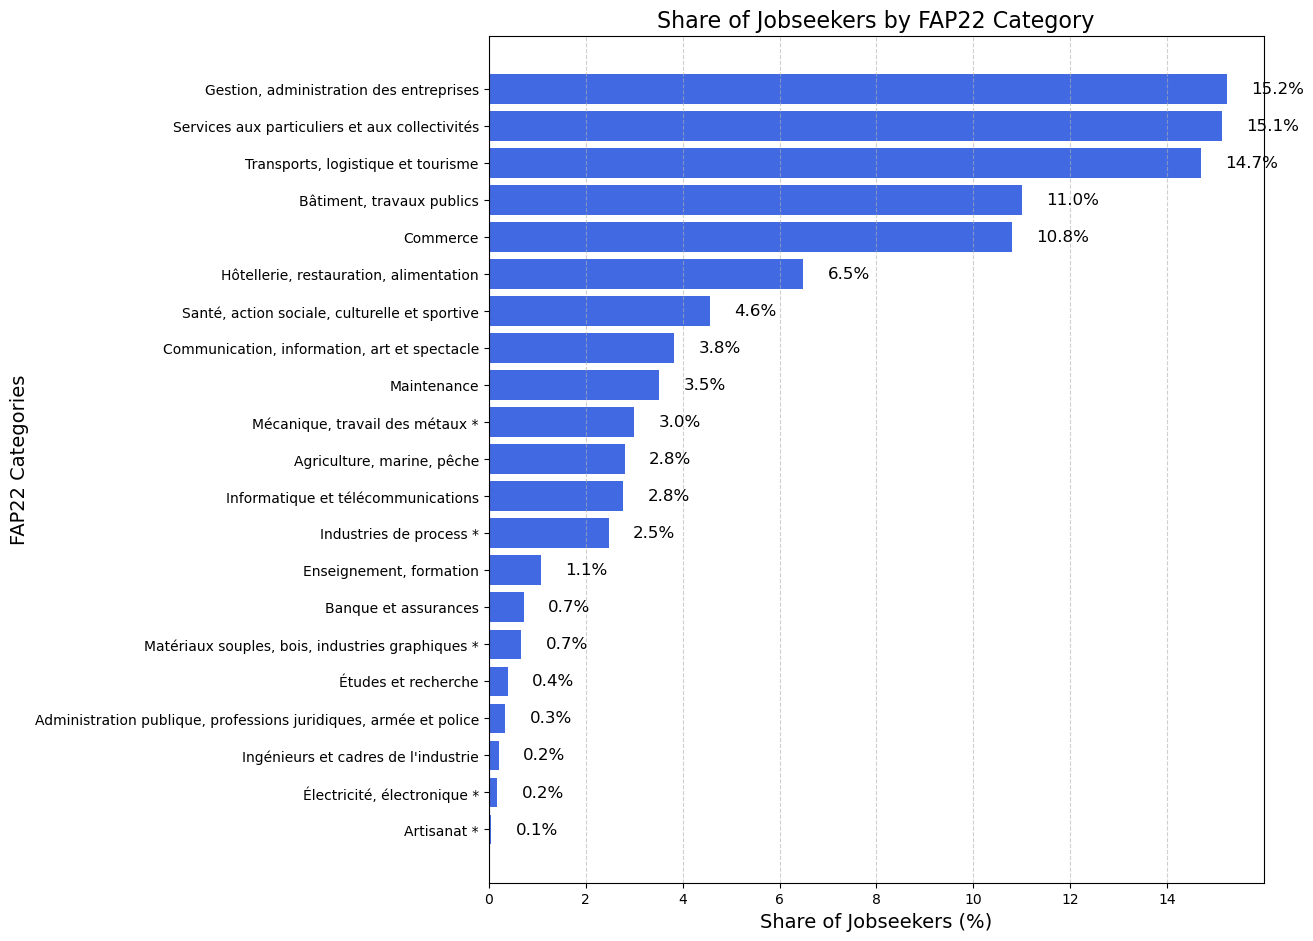

In [8]:
# Aggregate job offers at FAP22 level and compute share
job_fap22 = (df.groupby("fap87", as_index=False)["jobseeker_abc"].sum()
             .merge(rome_fap, on="fap87", how="left")
             .drop_duplicates("fap87")
             .groupby("famille_pro22", as_index=False)["jobseeker_abc"].sum())

job_fap22["share_of_demand"] = job_fap22["jobseeker_abc"] / job_fap22["jobseeker_abc"].sum() * 100
job_fap22 = job_fap22.sort_values("share_of_demand")

# Plot
plt.figure(figsize=(10, 11))
bars = plt.barh(job_fap22["famille_pro22"], job_fap22["share_of_demand"], color="royalblue")

# Labels and Titles
plt.xlabel("Share of Jobseekers (%)", fontsize=14)
plt.ylabel("FAP22 Categories", fontsize=14)
plt.title("Share of Jobseekers by FAP22 Category", fontsize=16)

# Add percentage labels next to each bar
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.1f}%", va="center", fontsize=12, color="black")

plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()